True communities: 2
Predicted communities: 2
Predicted communities Align: 2

Modularity: 0.3717948717948718
NMI: 0.8372
ARI: 0.8823
F1: 0.9706
Accuracy: 0.4706
Avg Execution time: 0.004942407608032226 seconds


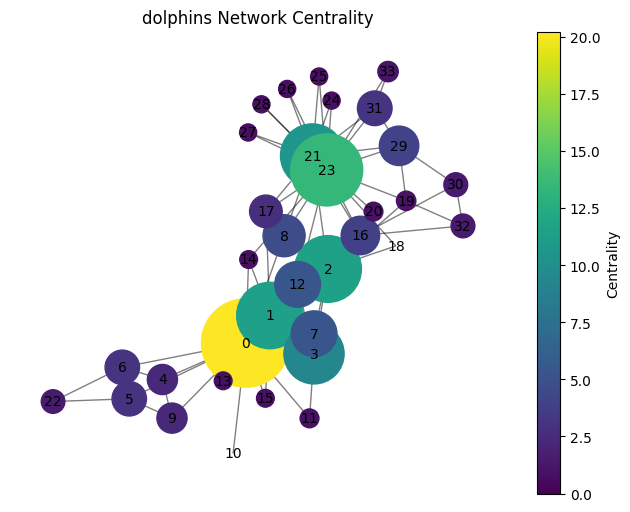

In [1]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math
from collections import defaultdict
import matplotlib.pyplot as plt

def load_dataset(dataset_name):
    datasets = {
        'football': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x)
        },
        'dolphins': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        },
        'karate': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/karate.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        }
    }
    if dataset_name not in datasets:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    dataset_info = datasets[dataset_name]
    url = dataset_info['url']
    label_attr = dataset_info['label_attr']
    label_transform = dataset_info['label_transform']

    local_filename = f"{dataset_name}.gml"
    response = requests.get(url)
    with open(local_filename, "wb") as f:
        f.write(response.content)

    G = nx.read_gml(local_filename, label='id')
    true_labels = np.array([label_transform(G.nodes[n][label_attr]) for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels


def adamic_adar_index(graph):
    similarities = defaultdict(dict)
    for u in graph.nodes:
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                common = neighbors_u & neighbors_v
                aa_score = 0.0
                for z in common:
                    degree_z = graph.degree(z)
                    if degree_z > 2:
                        aa_score += 1.0 / math.log(degree_z)
                if aa_score > 0.0:
                  similarities[u][v] = aa_score
    return similarities


# AA LPA with stronger cohesion
def AA_lpa(graph, similarities, max_iter=20):
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    while not converged and iter_count < max_iter:

        nodes_sorted = sorted(graph.nodes, key=lambda x: (-node_scores[x], x))
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        for n in graph.nodes:
            community_sizes[labels[n]] += 1

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                label_weights[l] += (similarities[node].get(v,0)*(community_sizes[l]))
            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]

                current_label = new_labels[node]
                if current_label not in candidates:
                    new_label= max(candidates, key=lambda x: node_scores[x])
                    new_labels[node] = new_label
                    changed += 1
                    #cent_scores = {l: max(node_scores[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    #new_label = max(cent_scores, key=cent_scores.get)

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])
def showCentrality(G,similarities):

      # Compute centrality scores: sum of each node's similarity values
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    # Extract scores in the same order as G.nodes()
    scores_list = [node_scores[node] for node in G.nodes()]

    # 3. Set up node size and color based on centrality
    #    Adjust the multiplication factor to get a good size range
    node_sizes = [score * 200 for score in scores_list]
    node_colors = scores_list

    # 4. Draw the network
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # positions for consistent layout

    # Draw nodes with a colormap, so each node is colored by its centrality score
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,   # You can try other color maps like 'plasma', 'coolwarm', etc.
    )

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos,font_size=10, font_color='black')

    # Add a colorbar to the plot
    cbar = plt.colorbar(nodes)
    cbar.set_label('Centrality')

    plt.title("dolphins Network Centrality")
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)
# Execution and Evaluation
G, true_labels = load_dataset('karate') #karate  or dolphins , football


execution_time=0
for i in range(100):
  start_time = time.time()
  # Execute and evaluate
  similarities = adamic_adar_index(G)
  pred_labels = AA_lpa(G,similarities)
  execution_time += (time.time() - start_time)
# Calculate metrics
aligned_pred = align_labels( true_labels,pred_labels)
unique_labels = np.unique(pred_labels)

predicted_communities = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

# Calculate metrics
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred ,average='micro' )
acc = accuracy_score(true_labels, pred_labels)
# Convert the predicted labels into community sets

modularity_score = modularity(G, predicted_communities)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Predicted communities Align: {len(np.unique(aligned_pred))}")

print(f'\nModularity: {modularity_score}')
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Avg Execution time: {execution_time/100} seconds")

showCentrality(G,similarities)